# Custom Object Detection with YOLOv3

Hey! Thanks for checking out this Jupyter Notebook. The goal of this notebook is to showcase how to train your own YOLOv3 model to perform real-time object detection. This trained model will later be exported to a Turtlebot3 to enhance the robot perception system. But for now, we will focus on the best methods to approach preparing our data and training the model, and test our findings on still images. Hope you enjoy!

Notebook was created by **Sam Cantor** for use in *QMIND* and the *DAIR-Perception* team.

## Testing the pre-trained YOLOv3 model

I want to give a huge thanks to Sergio Canu's tutorial on how to get started with YOLO using python and openCV. You can check it out [here](https://pysource.com/2019/06/27/yolo-object-detection-using-opencv-with-python/)

### Loading libraries and relevant files

We will be using *openCV* to interact with the YOLO algorithm. This framework is best for beginners to start with, but has a slower performance than other methods as it only work with CPU. *Darknet* and *Darkflow* can also be used.

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Next, let's load in the pre-trained YOLO model and the COCO dataset that it was trained on.

In [17]:
# Load YOLO
net = cv2.dnn.readNet("yolov3.weights","yolov3.cfg")
classes = []
with open("coco.names","r") as f:
    classes = [line.strip() for line in f.readlines()]

In [18]:
layer_names = net.getLayerNames()
outputlayers = [layer_names[i[0]-1]for i in net.getUnconnectedOutLayers()]

In [19]:
colors = np.random.uniform(0,255,size=(len(classes),3))

In [20]:
#load an image
img = cv2.imread("dogandhorsepic.jpg")
img = cv2.resize(img,None,fx=1.5,fy=1.3)
height,width,channels = img.shape
img_result = img.copy()

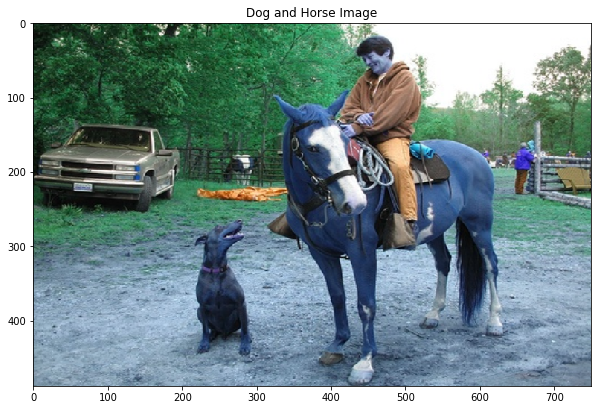

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title('Dog and Horse Image')
plt.show()

In [22]:
# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416,316), (0,0,0), True, crop=False)

In [23]:
# for b in blob:
#     for n,img_blob in enumerate(b):
#         cv2.imshow(str(n),img_blob)

In [24]:
net.setInput(blob)
outs = net.forward(outputlayers)
print(outs[1])

[[0.02599529 0.0297504  0.05962627 ... 0.         0.         0.        ]
 [0.01683626 0.02414035 0.3507023  ... 0.         0.         0.        ]
 [0.02303046 0.02407526 0.08258578 ... 0.         0.         0.        ]
 ...
 [0.9782416  0.97337496 0.03609551 ... 0.         0.         0.        ]
 [0.9832626  0.9758237  0.34377223 ... 0.         0.         0.        ]
 [0.9822391  0.9763198  0.06413222 ... 0.         0.         0.        ]]


In [25]:
class_ids=[]
confidences=[]
boxes=[]

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w = int(detection[2]*width)
            h = int(detection[3]*height)

            x=int(center_x - w/2)
            y=int(center_y - h/2)
            
            boxes.append([x,y,w,h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [26]:
font = cv2.FONT_HERSHEY_DUPLEX
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img_result, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img_result, label, (x, y + 30), font, 3, color, 3)

Let's take a look at the result...

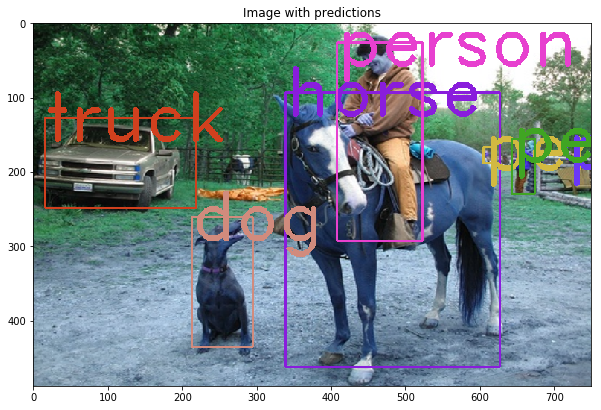

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(img_result)
plt.title('Image with predictions')
plt.show()

Looks like the code works as intended! We could also add the confidences and centerpoints of objects, but we'll leave that our for now.

## YOLO on a custom dataset
Now that we've successfuly tested the pre-trained YOLO model, let's try to get it working with our own custom dataset!

### Setting up our data
